In [ ]:
! pip install tiktoken transformers

In [10]:
import torch
import tiktoken
from model import GPTConfig, GPT

device = 'cuda'
init_from = 'gpt2-xl' # 'gpt2-xl'

model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)

enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

temperature = 0.8
top_k = 200

dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

loading weights from pretrained gpt: gpt2-xl
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 1555.97M


In [11]:
%load_ext autoreload
%autoreload 2

from model import GPTConfig, GPT
start = "What is the answer to life, the universe, and everything?"
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

max_new_tokens = 50

with torch.no_grad():
    with torch.amp.autocast(device_type=device, dtype=ptdtype):
        y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        print(decode(y[0].tolist()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
What is the answer to life, the universe, and everything? We are all too busy being consumed by daily demands to make time to truly reflect on and think things through. But here at Pest Control we think things through every day. Each day is a unique opportunity to think about the problems for ourselves and to


In [12]:
with open('../misc/data/asimov.txt', 'r') as f:
    text = f.read()
print(text[:1000])

PART I 

THE PSYCHOHISTORIANS 

i. 

HARI SELDON-... bom In the 1 1,988th year of the Galactic Era; died 12,069. The dates are 
more commonly given In terms of the current Foundational Era as - 79 to the year 1 F.E. Born 
to middle-class parents on Flelicon, Arcturus sector (where his father, In a legend of doubtful 
authenticity, was a tobacco grower in the hydroponic plants of the planet), he early showed 
amazing ability in mathematics. Anecdotes concerning his ability are innumerable, and some 
are contradictory. At the age of two, he is said to have ... 

... Undoubtedly his greatest contributions were in the field of psychohistory. Seldon found the 
field little more than a set of vague axioms; he left it a profound statistical science.... 

... The best existing authority we have for the details of his life is the biography written by Gaal 
Dornick who. as a young man, met Seldon two years before the great mathematician's death. 
The story of the meeting ... 

ENCYCLOPEDIA GALAC

In [39]:
import numpy as np
def process_stats(all_stats):
    # Cosine differences 0-1
    attn_mean = [stats['sim_attn'].mean().item() for stats in all_stats]
    mlp_mean = [stats['sim_mlp'].mean().item() for stats in all_stats]

    dist_attn = [stats['dist_attn'].mean().item() for stats in all_stats]
    dist_mlp = [stats['dist_mlp'].mean().item() for stats in all_stats]

    dist_attn_std, dist_mlp_std = [], []

    for stats in all_stats:
        dist_attn_std.append(stats['dist_attn'].std().item())
        dist_mlp_std.append(stats['dist_mlp'].std().item())

    return np.array(attn_mean), np.array(mlp_mean), np.array(dist_attn), np.array(dist_mlp), \
                np.array(dist_attn_std), np.array(dist_mlp_std)


def process_stats_batch(combined_stats):

    attn_mean, mlp_mean, dist_attn, dist_mlp, dist_attn_std, dist_mlp_std = process_stats(combined_stats[0])
    
    for i in range(1, len(combined_stats)):
        a, b, c, d, e, f = process_stats(combined_stats[i])
        attn_mean += a
        mlp_mean += b
        dist_attn += c
        dist_mlp += d
        dist_attn_std += e
        dist_mlp_std += f

    attn_mean = attn_mean / len(combined_stats)
    mlp_mean = mlp_mean / len(combined_stats)
    dist_attn = dist_attn / len(combined_stats)
    dist_mlp = dist_mlp / len(combined_stats)
    dist_attn_std = dist_attn_std / len(combined_stats)
    dist_mlp_std = dist_mlp_std / len(combined_stats)
    return attn_mean, mlp_mean, dist_attn, dist_mlp, dist_attn_std, dist_mlp_std

In [40]:
encoded_text = encode(text)
print(f'encoded_text.shape: {len(encoded_text):,}')

batches = 50
batch_size = 16
seq_len = 256

start_index = 0
combined_stats = []
with torch.no_grad():
    with torch.amp.autocast(device_type=device, dtype=ptdtype):
        for batches in range(batches):
            print(f'batch {batches} of {batches}. Start index: {start_index}')
            rows = []
            for i in range(batch_size):
                start_ids = encoded_text[start_index+i*seq_len:start_index + (i+1)*seq_len]
                rows.append(torch.tensor(start_ids, dtype=torch.long, device=device))
            x = torch.stack(rows)
            start_index += batch_size*seq_len
            _, _, _, all_stats = model.forward(x, store_kv_cache=False)
            combined_stats.append(all_stats)

encoded_text.shape: 326,911
batch 0 of 0. Start index: 0
batch 1 of 1. Start index: 4096
batch 2 of 2. Start index: 8192
batch 3 of 3. Start index: 12288
batch 4 of 4. Start index: 16384
batch 5 of 5. Start index: 20480
batch 6 of 6. Start index: 24576
batch 7 of 7. Start index: 28672
batch 8 of 8. Start index: 32768
batch 9 of 9. Start index: 36864
batch 10 of 10. Start index: 40960
batch 11 of 11. Start index: 45056
batch 12 of 12. Start index: 49152
batch 13 of 13. Start index: 53248
batch 14 of 14. Start index: 57344
batch 15 of 15. Start index: 61440
batch 16 of 16. Start index: 65536
batch 17 of 17. Start index: 69632
batch 18 of 18. Start index: 73728
batch 19 of 19. Start index: 77824
batch 20 of 20. Start index: 81920
batch 21 of 21. Start index: 86016
batch 22 of 22. Start index: 90112
batch 23 of 23. Start index: 94208
batch 24 of 24. Start index: 98304
batch 25 of 25. Start index: 102400
batch 26 of 26. Start index: 106496
batch 27 of 27. Start index: 110592
batch 28 of 28.

In [41]:
z = combined_stats[0][0]['sim_attn'].size()
print(f"Total elements: {len(combined_stats) * z[0] * z[1]} | batches: {len(combined_stats)} | batch_size: {z[0]} | elements: {z[1]}")

Total elements: 204800 | batches: 50 | batch_size: 16 | elements: 256


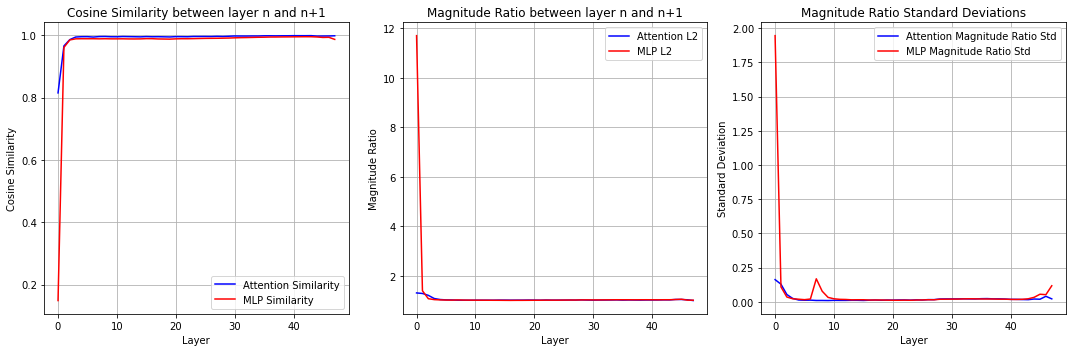

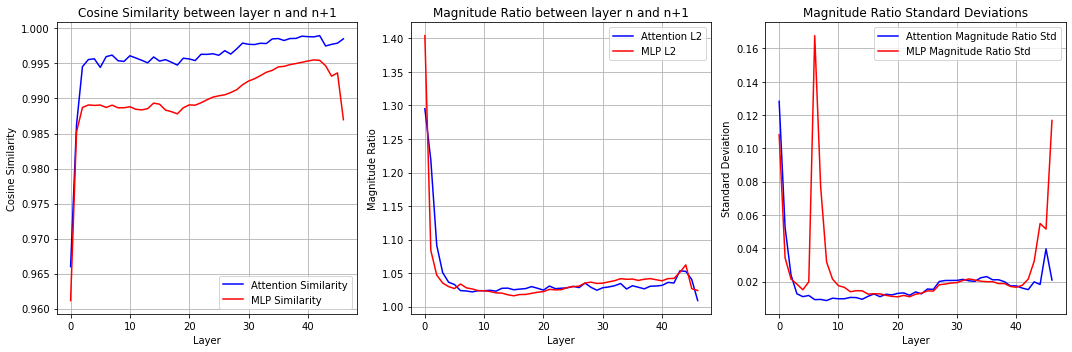

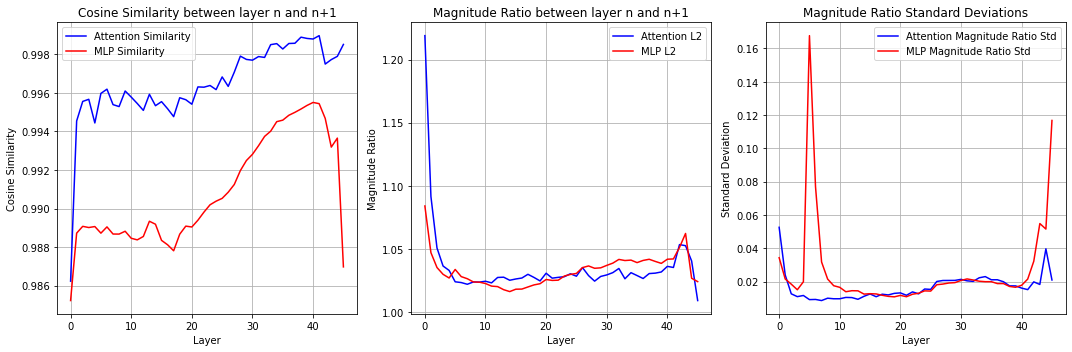

In [46]:
import os
import matplotlib.pyplot as plt

def plot_layer_analysis(combined_stats, layer_start=0, save_filename=None):
    attn_mean, mlp_mean, dist_attn, dist_mlp, dist_attn_std, dist_mlp_std = process_stats_batch(combined_stats)

    attn_mean = attn_mean[layer_start:]
    mlp_mean = mlp_mean[layer_start:]
    dist_attn = dist_attn[layer_start:]
    dist_mlp = dist_mlp[layer_start:]
    dist_attn_std = dist_attn_std[layer_start:]
    dist_mlp_std = dist_mlp_std[layer_start:]

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Attention vs MLP Similarities
    ax1.plot(attn_mean, 'b-', label='Attention Similarity')
    ax1.plot(mlp_mean, 'r-', label='MLP Similarity')
    ax1.set_title('Cosine Similarity between layer n and n+1')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Cosine Similarity')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: L2 Distances
    ax2.plot(dist_attn, 'b-', label='Attention L2')
    ax2.plot(dist_mlp, 'r-', label='MLP L2')
    ax2.set_title('Magnitude Ratio between layer n and n+1')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Magnitude Ratio')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: L2 Distance Standard Deviations
    ax3.plot(range(len(dist_attn_std)), dist_attn_std, 'b-', label='Attention Magnitude Ratio Std')
    ax3.plot(range(len(dist_mlp_std)), dist_mlp_std, 'r-', label='MLP Magnitude Ratio Std')
    ax3.set_title('Magnitude Ratio Standard Deviations')
    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Standard Deviation')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    if save_filename is not None:
        os.makedirs('layer_analysis', exist_ok=True)
        plt.savefig(f'layer_analysis/{save_filename}.png')
    plt.show()

plot_layer_analysis(combined_stats, save_filename='gpt_2_xl_full')
plot_layer_analysis(combined_stats, layer_start=1, save_filename='gpt_2_xl_layer_1_start')
plot_layer_analysis(combined_stats, layer_start=2, save_filename='gpt_2_xl_layer_2_start')

In [ ]:
stats

In [ ]:
len(all_stats)

In [ ]:
all_stats[0]['sim_attn']

In [ ]:
all_stats